In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import community.community_louvain as community

In [5]:
# load data
city_name = 'Sicklerville'
nodes_edges_name = 'mixed'

nodes = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_edges.csv')

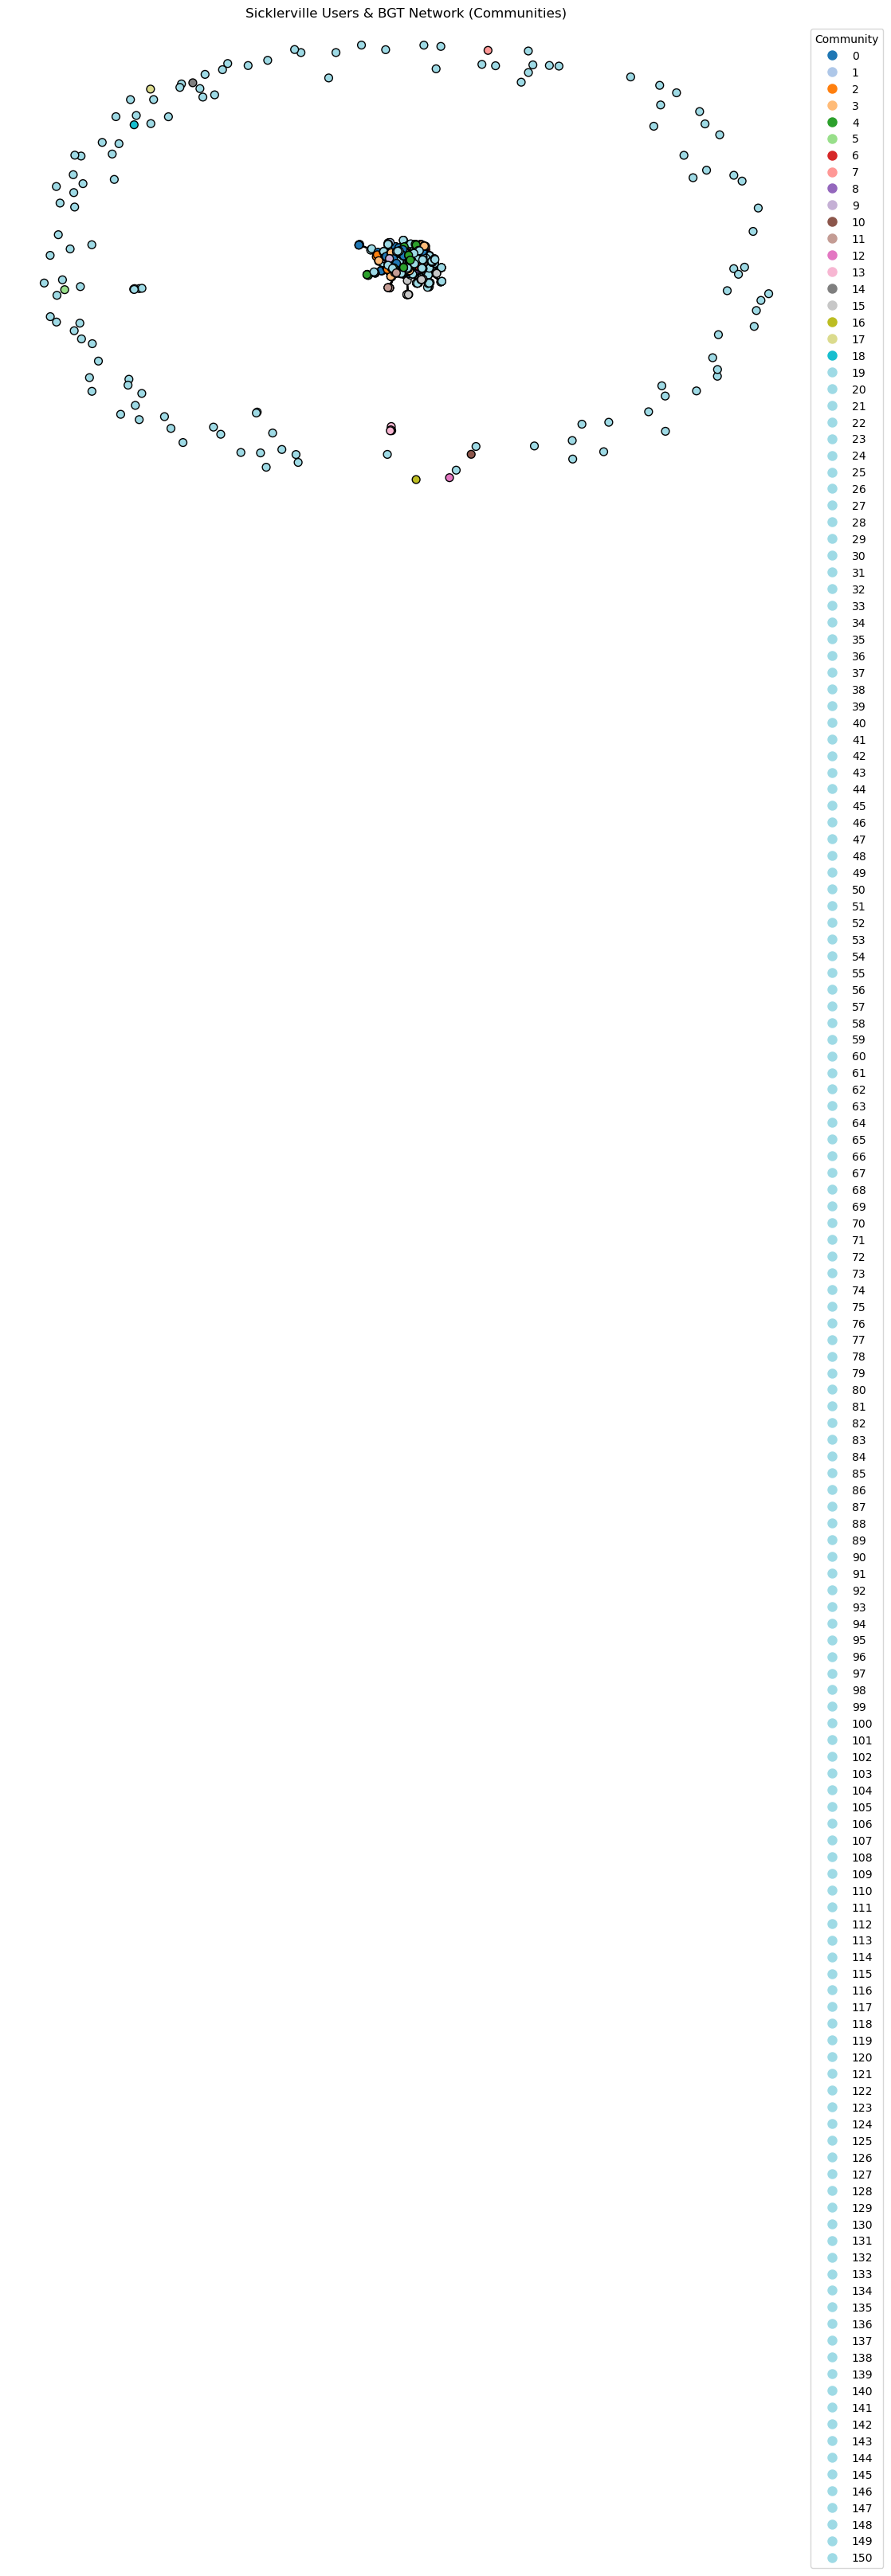

In [6]:
G = nx.Graph()

for _, row in nodes.iterrows():
    G.add_node(row['id'], name=row['people_name'])

for _, row in edges.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['weight'], type=row['type'])

eba = community.best_partition(G)

palette = plt.get_cmap('tab20')

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos,
        node_color=[palette(eba[node]) for node in G.nodes()],
        node_size=50,
        edge_color='black',
        edgecolors='black',
        width=1,
        with_labels=False)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette(i), markersize=10, label=str(i)) 
                  for i in range(len(set(eba.values())))]
plt.legend(handles=legend_handles, title='Community', bbox_to_anchor=(1, 1), loc='upper left')

plt.title(f"{city_name} Users & BGT Network (Communities)")
plt.show()

In [7]:
# load data
city_name = 'Dublin'
nodes_edges_name = 'categories'

nodes = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_edges.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'nodes_and_edges/Dublin_categories_nodes.csv'

In [ ]:
G = nx.Graph()

for _, row in nodes.iterrows():
    G.add_node(row['id'], name=row['people_name'])

for _, row in edges.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['weight'], type=row['type'])

partition = community.best_partition(G)

palette = plt.get_cmap('tab20')

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos,
        node_color=[palette(partition[node]) for node in G.nodes()],
        node_size=50,
        edge_color='black',
        edgecolors='black',
        width=1,
        with_labels=False)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette(i), markersize=10, label=str(i)) 
                  for i in range(len(set(partition.values())))]
plt.legend(handles=legend_handles, title='Community', bbox_to_anchor=(1, 1), loc='upper left')

plt.title("Dublin Users & Categories Reviewed (Communities)")
plt.show()

In [ ]:
from utils import load_filtered_data
from surprise.model_selection import train_test_split, cross_validate
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD, accuracy
import random

data = load_filtered_data(city_name)

In [ ]:
# Define evaluation function
def evaluate_algorithm(algo, trainset, testset):
    algo.fit(trainset)
    predictions = algo.test(testset)
    
    # Compute and return RMSE
    rmse = accuracy.rmse(predictions)
    return rmse

In [ ]:
# Recommend top N items for a user using a recommender model
def recommend_top_n(algo, trainset, user_id, n=10):
    user_ratings = trainset.ur[user_id]
    items = [item_id for (item_id, _) in user_ratings]
    
    item_scores = {}
    # this is actually not the most correct way to do this, but it works
    for item_id in trainset.all_items():
        if item_id not in items:
            prediction = algo.predict(trainset.to_raw_uid(user_id), trainset.to_raw_iid(item_id), verbose=True)
            item_scores[item_id] = prediction.est
    
    top_items = sorted(item_scores, key=item_scores.get, reverse=True)[:n]

    #from raw_id to actual_id
    return [trainset.to_raw_iid(i) for i in top_items]

def get_users(df_testset, trainset):
    # we just want to recommend positive ratings
    pos_rating = 3
    df_testset_pos = df_testset[df_testset["stars_x"] > pos_rating]
    # which users exist in the training and testset
    users = []
    for u in df_testset_pos["user_id"].unique():
        try :
            trainset.to_inner_uid(u)
            users.append(u)
        except ValueError:
            continue
    return users

In [ ]:

merged_reviews = pd.merge(data['review'], data['user'], on='user_id', how='left')
merged_reviews = pd.merge(merged_reviews, data['business'], on='business_id', how='left')
merged_reviews = merged_reviews# Function to convert DataFrame to Surprise dataset
def create_surprise_dataset(data):
    reader = Reader(rating_scale=(1, 5))  # Ratings scale is from 1 to 5
    return Dataset.load_from_df(data[['user_id', 'business_id', 'stars_x']], reader).drop_duplicates(subset=['user_id', 'business_id'])

# Function to convert DataFrame to Surprise dataset
def create_surprise_dataset(data):
    reader = Reader(rating_scale=(1, 5))  # Ratings scale is from 1 to 5
    return Dataset.load_from_df(data[['user_id', 'business_id', 'stars_x']], reader)

# Function to get recommendations for a community
def get_community_recommendations(community_id, reviews_data, min_ratings_for_split=5, test_size=0.2):
    global count
    community_users = [user for user, com_id in partition.items() if com_id == community_id]
    community_reviews = reviews_data[reviews_data['user_id'].isin(community_users)]
    
    if len(community_reviews) < min_ratings_for_split:
        count = count + 1
        return None
    
    surprise_dataset = create_surprise_dataset(community_reviews)
    
    trainset, testset = train_test_split(surprise_dataset, test_size=test_size)
    df_testset = pd.DataFrame(testset, columns=['user_id', 'business_id', 'stars_x'])
    df_testset.groupby("user_id").apply(len).value_counts()
    users = get_users(df_testset, trainset)

    ubcf_algo = KNNBasic(sim_options={'user_based': True})
    ubcf_rmse = evaluate_algorithm(ubcf_algo, trainset, testset)
    random_user = random.choice(users)
    n = 5
    gt = df_testset[(df_testset['user_id']==random_user) & (df_testset['stars_x']>3)].business_id.to_list()
    print("ground truth : ", gt)
    recs =  recommend_top_n(ubcf_algo, trainset, trainset.to_inner_uid(random_user), n)
    print("recommendations: ",recs)
    print(f"hits: {len(set(gt).intersection(set(recs)))} / {n}")

    
    return ubcf_rmse

# Generate recommendations for each community
community_recommendations = {}
count = 0
for community_id in set(partition.values()):
    recommendation = get_community_recommendations(community_id, merged_reviews)
    if recommendation is not None:
        community_recommendations[community_id] = recommendation



NameError: name 'pd' is not defined